In [132]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/nlp/Data.csv' 'Data.csv'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [133]:
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm
import torch

In [134]:

df = pd.read_csv('Data.csv')
df.head()

,English,Spanish
0,With 22% of its student body coming from abroa...,Con el 22 % de su alumnado procedente del extr...
1,Yale’s history of including international stud...,La historia de Yale de incluir estudiantes int...
2,"Today, Yale welcomes the largest international...","\r\nHoy, Yale da la bienvenida a la comunidad ..."
3,Applying to Yale,Aplicar a Yale
4,"To be considered for acceptance to Yale, inter...",Para ser considerado para la aceptación en Yal...


In [135]:

def cleanerEng(x):
  x = str(x)
  x = x.lower()
  x = re.sub(r'[^a-z0-9]+',' ',x)
  return x

def cleanerSpanish(x):
  x = str(x)
  pattern = r'\b[a-záéíóúñü]+\b'
  x = re.sub(pattern, '', x)
  return x

In [136]:
df.iloc[:,0] = df['English'].apply(func=cleanerEng)
df.iloc[:,1] = df['Spanish'].apply(func= cleanerSpanish)
df.iloc[:,0] = df['English'].apply(func= lambda x : (str(x).split()))
df.iloc[:,1] = df['Spanish'].apply(func= lambda x : (str(x).split()))

In [137]:
def addTokens(x,start=False):
  x.append('<END>')
  if start:
    x.insert(0,'<START>')
  return list(x)

In [138]:
df.iloc[:,0] = df['English'].apply(func= addTokens,start=False)
df.iloc[:,1] = df['Spanish'].apply(func= addTokens,start=True)

In [139]:
df.iloc[79,1]

['<START>',
 'El',
 'Facultad',
 'Derecho',
 'Yale',
 'Argentina,',
 'Brasil',
 'Chile',
 '<END>']

In [140]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random

In [141]:
data[:,1].shape

(108,)

In [142]:
class vocab:

  def __init__(self,data,token=True):
    self.data = data
    if token:
      self.word2idx = {'<START>':1, '<END>':2, '<PAD>':0}
      self.idx2word = {1:'<START>', 2:'<END>', 0:'<PAD>'}
      self.idx = 2

    else:
      self.word2idx = {'<PAD>':0, '<END>':1}
      self.idx2word = {0:'<PAD>', 1:'<END>'}
      self.idx = 1

    self.x = []
    self.create()
    self.vocab_size = self.idx + 1

  def create(self):
    max_len = 0;
    for sentence in  self.data:
      max_len = max(max_len, len(sentence))
      for word in sentence:
        if self.word2idx.get(word) is None:
          self.idx += 1
          self.word2idx[word] = self.idx
          self.idx2word[self.idx] = word
    
    for sentence in self.data:
      sent = []
      for word in sentence:
        sent.append(self.word2idx[word])
      
      for i in range(len(sentence),max_len+1):
        sent.append(0)
      
      self.x.append(torch.Tensor(sent))

    

In [143]:
English_vocab = vocab(data[:,0],token=False)
Spanish_vocab = vocab(data[:,1],token=True)

In [144]:
for idx in Spanish_vocab.x[2]:
  print(Spanish_vocab.idx2word[int(idx)],end=' ')

<START> Entrelazó . <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

In [145]:
class parallelData(Dataset):

  def __init__(self):
    self.x = English_vocab.x
    self.y = Spanish_vocab.x

  def __getitem__(self,i):
    return self.x[i], self.y[i]
  
  def __len__(self):
    return len(self.x)


In [146]:
dataset = parallelData()

In [147]:
a = dataset[0][0].shape[0]
b = dataset[0][1].shape[0]
for i in range(len(dataset)):
  if a != dataset[i][0].shape[0] or b != dataset[i][1].shape[0]:
    print(a,dataset[i][0].shape[0],b,dataset[i][1].shape[0])

In [148]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=100)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=100)

print("Number of samples in train set:", len(train_data))
print("Number of samples in test set:", len(test_data))
print("Number of samples in validation set:", len(val_data))

Number of samples in train set: 108
Number of samples in test set: 14
Number of samples in validation set: 14


In [149]:
#Model

class encoder(nn.Module):

  def __init__(self, input_size, embedding_size, hidden_size, layers):
    '''
    input_size = size of vocab
    embedding_size = embedding dim
    hidden_size = hidden state size
    layer = num of layers of lstms
    '''
    super().__init__()
    self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size) # output size = (*,embedding_size)
    self.lstm = nn.LSTM(input_size=embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True)

  def forward(self,x):
    '''
    x shape = [batch_size, sentence]
    one complete sentence represents a "sequence"
    '''
    x = self.embed(x) # shape [batch_size,  sentence, embed_size]
    output, (hidden_state, cell_state) = self.lstm(x) #shape [batch_size, seq_len, hidden_size]

    return hidden_state, cell_state


class decoder(nn.Module):

  def __init__(self,input_size, embedding_size, hidden_size, layers):
    '''
    same configuration as encoder
    here input_size = size of Spanish vocab
    '''
    super().__init__()
    self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size) # output size = (*,embedding_size)
    self.lstm = nn.LSTM(input_size=embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True)
    self.fc = nn.Linear(in_features=hidden_size, out_features=input_size) #since output would be prob distribution among Spanish vocab therefore out_feature=input_size

  def forward(self,x,hidden_state, cell_state):
    '''
    to have control over output we have to take sentence as word by word
    therefore seq_len would be 1 as input is  one word not the whole sentence
    x = [batch_size] ->required-> [batch_size, 1] (1 is seq_len)
    '''
    # print(x.shape)
    x = x.reshape(-1,1) # shape [batch, 1]
    # print(x.shape)
    x = self.embed(x) # shape [batch, 1, embed_dim]

    output, (hidden_state, cell_state) = self.lstm(x, (hidden_state, cell_state)) # shape output=>[batch, 1, hidden_size], hidden=>[layers, batch, hidden_size]
    output = self.fc(output) # shape [batch, 1, Spanish_vocab_size]
    
    #just for removing extra dim
    output = output.squeeze(dim=1) #shape [batch, Spanish_vocab_size]

    return output, hidden_state, cell_state



class seq2seq(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder


  def forward(self, input, target, teaching_force=0.5):
    '''
    input = batch of english sentences[batch, sentece(padded)]
    target = batch of spanish sentences [batch, sentence(padded)] 
    '''
    batch_size = input.shape[0]
    seq_len = target.shape[1]
    Spanish_vocab_size = Spanish_vocab.vocab_size

    output = torch.zeros((seq_len, batch_size, Spanish_vocab_size)).to(device)

    hidden, cell = self.encoder(input)
    target = target.permute(1,0) # shape [seq, batch]
    x = target[0] # <START> token

    for i in range(1, seq_len):
      out, hidden, cell = self.decoder(x, hidden, cell) #out shape = [batch, vocab_size]
      output[i] = out
      decoder_guess = out.argmax(1)# taking the word with max value(confidence)  shape = [batch of words]

      if random.random() < teaching_force:
        x = target[i]
      else:
        x =  decoder_guess
    
    return output  #shape[seq_len, batch_size, vocab_size]


In [150]:
#Hyperparameters
epochs = 100
learning_rate = 0.001
batch_size = 8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_size = 200
hidden_size = 512
layers = 1


In [151]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [152]:

it = iter(loader)
x,y = next(it)
print(x.shape,y.shape)

torch.Size([8, 34]) torch.Size([8, 15])


In [153]:
ENC = encoder(English_vocab.vocab_size, embedding_size, hidden_size, layers).to(device)
DE = decoder(Spanish_vocab.vocab_size, embedding_size, hidden_size, layers).to(device)
model = seq2seq(ENC,DE).to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)


In [154]:
train_loss = []
for epoch in tqdm(range(epochs)):
  for id,(x,y) in (enumerate(tqdm(loader))):
    x = x.long().to(device)
    y = y.long().to(device)#[batch,seq]

    output = model(x,y,1)# [seq, batch, vocab]
    output = output[1:].reshape(-1,output.shape[2])
    y = y.permute(1,0)#[seq, batch]
    y = y[1:].reshape(-1)

    optimizer.zero_grad()
    loss = criterion(output,y)

    loss.backward()
    optimizer.step()

    # if id%20 == 0:
  print(f'[{epoch+1}/{epochs}] loss=>{loss.item()}')
  train_loss.append(loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[1/100] loss=>4.855987071990967


  0%|          | 0/14 [00:00<?, ?it/s]

[2/100] loss=>2.789945125579834


  0%|          | 0/14 [00:00<?, ?it/s]

[3/100] loss=>2.661773681640625


  0%|          | 0/14 [00:00<?, ?it/s]

[4/100] loss=>2.1909072399139404


  0%|          | 0/14 [00:00<?, ?it/s]

[5/100] loss=>2.5667455196380615


  0%|          | 0/14 [00:00<?, ?it/s]

[6/100] loss=>2.563469171524048


  0%|          | 0/14 [00:00<?, ?it/s]

[7/100] loss=>2.2206766605377197


  0%|          | 0/14 [00:00<?, ?it/s]

[8/100] loss=>2.047863006591797


  0%|          | 0/14 [00:00<?, ?it/s]

[9/100] loss=>1.0988630056381226


  0%|          | 0/14 [00:00<?, ?it/s]

[10/100] loss=>1.4327598810195923


  0%|          | 0/14 [00:00<?, ?it/s]

[11/100] loss=>1.2497227191925049


  0%|          | 0/14 [00:00<?, ?it/s]

[12/100] loss=>1.275317668914795


  0%|          | 0/14 [00:00<?, ?it/s]

[13/100] loss=>1.1214388608932495


  0%|          | 0/14 [00:00<?, ?it/s]

[14/100] loss=>1.2634148597717285


  0%|          | 0/14 [00:00<?, ?it/s]

[15/100] loss=>0.679198682308197


  0%|          | 0/14 [00:00<?, ?it/s]

[16/100] loss=>1.2288306951522827


  0%|          | 0/14 [00:00<?, ?it/s]

[17/100] loss=>0.8882902264595032


  0%|          | 0/14 [00:00<?, ?it/s]

[18/100] loss=>1.2398157119750977


  0%|          | 0/14 [00:00<?, ?it/s]

[19/100] loss=>1.312965750694275


  0%|          | 0/14 [00:00<?, ?it/s]

[20/100] loss=>1.6511069536209106


  0%|          | 0/14 [00:00<?, ?it/s]

[21/100] loss=>0.8978753089904785


  0%|          | 0/14 [00:00<?, ?it/s]

[22/100] loss=>0.7269558310508728


  0%|          | 0/14 [00:00<?, ?it/s]

[23/100] loss=>0.827553927898407


  0%|          | 0/14 [00:00<?, ?it/s]

[24/100] loss=>0.7918221950531006


  0%|          | 0/14 [00:00<?, ?it/s]

[25/100] loss=>1.6180768013000488


  0%|          | 0/14 [00:00<?, ?it/s]

[26/100] loss=>0.9754465222358704


  0%|          | 0/14 [00:00<?, ?it/s]

[27/100] loss=>1.8369395732879639


  0%|          | 0/14 [00:00<?, ?it/s]

[28/100] loss=>0.6264457702636719


  0%|          | 0/14 [00:00<?, ?it/s]

[29/100] loss=>0.7437238097190857


  0%|          | 0/14 [00:00<?, ?it/s]

[30/100] loss=>0.7398917078971863


  0%|          | 0/14 [00:00<?, ?it/s]

[31/100] loss=>0.766713559627533


  0%|          | 0/14 [00:00<?, ?it/s]

[32/100] loss=>0.7180076241493225


  0%|          | 0/14 [00:00<?, ?it/s]

[33/100] loss=>0.7328326106071472


  0%|          | 0/14 [00:00<?, ?it/s]

[34/100] loss=>1.1036432981491089


  0%|          | 0/14 [00:00<?, ?it/s]

[35/100] loss=>0.624238908290863


  0%|          | 0/14 [00:00<?, ?it/s]

[36/100] loss=>0.9630159735679626


  0%|          | 0/14 [00:00<?, ?it/s]

[37/100] loss=>1.02413010597229


  0%|          | 0/14 [00:00<?, ?it/s]

[38/100] loss=>0.6186177134513855


  0%|          | 0/14 [00:00<?, ?it/s]

[39/100] loss=>0.5439703464508057


  0%|          | 0/14 [00:00<?, ?it/s]

[40/100] loss=>0.7837182283401489


  0%|          | 0/14 [00:00<?, ?it/s]

[41/100] loss=>0.5261433720588684


  0%|          | 0/14 [00:00<?, ?it/s]

[42/100] loss=>0.6148520708084106


  0%|          | 0/14 [00:00<?, ?it/s]

[43/100] loss=>0.5168611407279968


  0%|          | 0/14 [00:00<?, ?it/s]

[44/100] loss=>0.6698067784309387


  0%|          | 0/14 [00:00<?, ?it/s]

[45/100] loss=>0.411121129989624


  0%|          | 0/14 [00:00<?, ?it/s]

[46/100] loss=>0.4421241879463196


  0%|          | 0/14 [00:00<?, ?it/s]

[47/100] loss=>0.41010016202926636


  0%|          | 0/14 [00:00<?, ?it/s]

[48/100] loss=>0.36243852972984314


  0%|          | 0/14 [00:00<?, ?it/s]

[49/100] loss=>0.8904733657836914


  0%|          | 0/14 [00:00<?, ?it/s]

[50/100] loss=>0.35993868112564087


  0%|          | 0/14 [00:00<?, ?it/s]

[51/100] loss=>0.494637131690979


  0%|          | 0/14 [00:00<?, ?it/s]

[52/100] loss=>0.3490924835205078


  0%|          | 0/14 [00:00<?, ?it/s]

[53/100] loss=>0.2276880294084549


  0%|          | 0/14 [00:00<?, ?it/s]

[54/100] loss=>0.18499580025672913


  0%|          | 0/14 [00:00<?, ?it/s]

[55/100] loss=>0.2682560682296753


  0%|          | 0/14 [00:00<?, ?it/s]

[56/100] loss=>0.22820836305618286


  0%|          | 0/14 [00:00<?, ?it/s]

[57/100] loss=>0.5472615361213684


  0%|          | 0/14 [00:00<?, ?it/s]

[58/100] loss=>0.25735142827033997


  0%|          | 0/14 [00:00<?, ?it/s]

[59/100] loss=>0.14446479082107544


  0%|          | 0/14 [00:00<?, ?it/s]

[60/100] loss=>0.24235917627811432


  0%|          | 0/14 [00:00<?, ?it/s]

[61/100] loss=>0.31620898842811584


  0%|          | 0/14 [00:00<?, ?it/s]

[62/100] loss=>0.46923696994781494


  0%|          | 0/14 [00:00<?, ?it/s]

[63/100] loss=>0.2334991842508316


  0%|          | 0/14 [00:00<?, ?it/s]

[64/100] loss=>0.07213913649320602


  0%|          | 0/14 [00:00<?, ?it/s]

[65/100] loss=>0.8351064920425415


  0%|          | 0/14 [00:00<?, ?it/s]

[66/100] loss=>0.2234019786119461


  0%|          | 0/14 [00:00<?, ?it/s]

[67/100] loss=>0.1684788316488266


  0%|          | 0/14 [00:00<?, ?it/s]

[68/100] loss=>0.17176209390163422


  0%|          | 0/14 [00:00<?, ?it/s]

[69/100] loss=>0.20209850370883942


  0%|          | 0/14 [00:00<?, ?it/s]

[70/100] loss=>0.15000662207603455


  0%|          | 0/14 [00:00<?, ?it/s]

[71/100] loss=>0.10470670461654663


  0%|          | 0/14 [00:00<?, ?it/s]

[72/100] loss=>0.08184580504894257


  0%|          | 0/14 [00:00<?, ?it/s]

[73/100] loss=>0.031463395804166794


  0%|          | 0/14 [00:00<?, ?it/s]

[74/100] loss=>0.02357729896903038


  0%|          | 0/14 [00:00<?, ?it/s]

[75/100] loss=>0.09350568801164627


  0%|          | 0/14 [00:00<?, ?it/s]

[76/100] loss=>0.034696441143751144


  0%|          | 0/14 [00:00<?, ?it/s]

[77/100] loss=>0.027655355632305145


  0%|          | 0/14 [00:00<?, ?it/s]

[78/100] loss=>0.01818888634443283


  0%|          | 0/14 [00:00<?, ?it/s]

[79/100] loss=>0.07823910564184189


  0%|          | 0/14 [00:00<?, ?it/s]

[80/100] loss=>0.02660619467496872


  0%|          | 0/14 [00:00<?, ?it/s]

[81/100] loss=>0.03879726305603981


  0%|          | 0/14 [00:00<?, ?it/s]

[82/100] loss=>0.018602462485432625


  0%|          | 0/14 [00:00<?, ?it/s]

[83/100] loss=>0.011223453097045422


  0%|          | 0/14 [00:00<?, ?it/s]

[84/100] loss=>0.030758801847696304


  0%|          | 0/14 [00:00<?, ?it/s]

[85/100] loss=>0.01937221549451351


  0%|          | 0/14 [00:00<?, ?it/s]

[86/100] loss=>0.012165362015366554


  0%|          | 0/14 [00:00<?, ?it/s]

[87/100] loss=>0.0173012837767601


  0%|          | 0/14 [00:00<?, ?it/s]

[88/100] loss=>0.00910048559308052


  0%|          | 0/14 [00:00<?, ?it/s]

[89/100] loss=>0.01966724544763565


  0%|          | 0/14 [00:00<?, ?it/s]

[90/100] loss=>0.010586784221231937


  0%|          | 0/14 [00:00<?, ?it/s]

[91/100] loss=>0.006941426079720259


  0%|          | 0/14 [00:00<?, ?it/s]

[92/100] loss=>0.026797039434313774


  0%|          | 0/14 [00:00<?, ?it/s]

[93/100] loss=>0.005423391703516245


  0%|          | 0/14 [00:00<?, ?it/s]

[94/100] loss=>0.014139503240585327


  0%|          | 0/14 [00:00<?, ?it/s]

[95/100] loss=>0.014802953228354454


  0%|          | 0/14 [00:00<?, ?it/s]

[96/100] loss=>0.008607976138591766


  0%|          | 0/14 [00:00<?, ?it/s]

[97/100] loss=>0.013197511434555054


  0%|          | 0/14 [00:00<?, ?it/s]

[98/100] loss=>0.010470184497535229


  0%|          | 0/14 [00:00<?, ?it/s]

[99/100] loss=>0.006510472856462002


  0%|          | 0/14 [00:00<?, ?it/s]

[100/100] loss=>0.006058666855096817


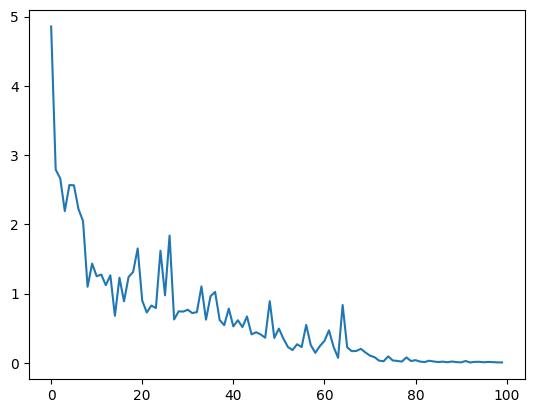

In [155]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.show()

In [156]:
def predict(x):
    for idx in x:
      if idx == 0:
        break
      print(English_vocab.idx2word[int(idx)],end=' ')
    
    print()

    x = x.long().reshape(1,-1).to(device)
    ans = translate(x)
    for id in ans:
      print(Spanish_vocab.idx2word[id],end=' ');

    print()
    

    


In [157]:
def translate(input):
      #input = batch of english sentences[batch, sentece(padded)]
      with torch.no_grad():
        guess = []
        hidden, cell = model.encoder(input)
        # x = torch.ones((1)).float().to(device) # <START> token
        x = torch.ones((1)).long().to(device)
        while True:
          out, hidden, cell = model.decoder(x, hidden, cell) #out shape = [batch, vocab_size]
          x = out.argmax(1)# taking the word with max value(confidence)  shape = [batch of words]
          guess.append(int(x[0].detach().cpu()))

          if x == 2:
            break

      return guess

In [158]:
predict(dataset[10][0])

world fellows are required to be in residence at yale university in new haven for the entirety of the program which runs from mid august through mid december <END> 
Se World Fellows Universidad Yale New Haven , . <END> 


In [159]:
predict(dataset[8][0])

at the end of the program the group travels to new york to observe hearings at the second district federal court of appeals <END> 
Al , Nueva York Corte Federal Apelaciones Segundo Distrito <END> 


In [160]:
predict(dataset[11][0])

the yale school of art has a long and distinguished history of training artists of the highest caliber <END> 
La Escuela Arte Yale . <END> 


In [205]:
def actutal_output(output_tensor):
    output = str()
    for i in output_tensor:
        if i.item() not in [0.,1.,2.]:
            output += " "+ Spanish_vocab.idx2word.get(i.item())
    return output

In [212]:
actutal_output(dataset[8][1])

' Al , Nueva York Corte Federal Apelaciones Segundo Distrito'

In [215]:
actutal_output(dataset[10][1])

' Se World Fellows Universidad Yale New Haven , .'

In [193]:
import nltk

predicted_output = "La Escuela Arte Yale . <END>"
actual_output = "La Escuela Arte Yale ."

# split the strings into lists of tokens
predicted_tokens = predicted_output.split()
actual_tokens = actual_output.split()

# calculate the BLEU score
bleu_score = nltk.translate.bleu_score.sentence_bleu([actual_tokens], predicted_tokens)

print("BLEU score:", bleu_score)


BLEU score: 0.7598356856515925


In [214]:
import nltk

predicted_output = "Al , Nueva York Corte Federal Apelaciones Segundo Distrito <END>"
actual_output = " Al , Nueva York Corte Federal Apelaciones Segundo Distrito"

# split the strings into lists of tokens
predicted_tokens = predicted_output.split()
actual_tokens = actual_output.split()

# calculate the BLEU score
bleu_score = nltk.translate.bleu_score.sentence_bleu([actual_tokens], predicted_tokens)

print("BLEU score:", bleu_score)

BLEU score: 0.8801117367933934


In [216]:
import nltk

predicted_output = "Se World Fellows Universidad Yale New Haven , . <END>  "
actual_output = "  Se World Fellows Universidad Yale New Haven , ."

# split the strings into lists of tokens
predicted_tokens = predicted_output.split()
actual_tokens = actual_output.split()

# calculate the BLEU score
bleu_score = nltk.translate.bleu_score.sentence_bleu([actual_tokens], predicted_tokens)

print("BLEU score:", bleu_score)

BLEU score: 0.8801117367933934
